## Init Spark

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-titanic-exe")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

## ETL

In [2]:
from pathlib import Path
import pandas as pd

In [3]:
def extract_trollers_data(url, refresh_cache=False):
    cache_fn = Path('/dataset/trollers.csv')
    if not cache_fn.exists() or refresh_cache:
        print("Getting data")
        df = pd.read_csv(url)
        df.to_csv(cache_fn, index=False)
    print("Using cache")
    df = spark.read.csv(str(cache_fn), header=True)
    return df

In [4]:
url = 'https://raw.githubusercontent.com/nmarcovecchio/bigdata-workshop-es/master/dataset/GFW_2020/trollers.csv'

In [5]:
df_raw = extract_trollers_data(url)

Using cache


In [6]:
from pyspark.sql.types import DoubleType, IntegerType

def cast_cols(df, cols, new_type):
    for col in cols: 
         df = df.withColumn(col, df[col].cast(new_type()))
    return df

integer_cols = ['timestamp']
float_cols = ['distance_from_shore', 'distance_from_port', 'speed', 'course', 'lat', 'lon', 'is_fishing']

df_raw = cast_cols(df_raw, integer_cols, IntegerType)
df_raw = cast_cols(df_raw, float_cols, DoubleType)

In [7]:
df_raw.printSchema()

root
 |-- mmsi: string (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- distance_from_shore: double (nullable = true)
 |-- distance_from_port: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- course: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- is_fishing: double (nullable = true)
 |-- source: string (nullable = true)



In [8]:
df_raw.count()

166243

In [9]:
df_raw.select('is_fishing').groupBy('is_fishing').count().show()

+----------+------+
|is_fishing| count|
+----------+------+
|       1.0|  2966|
| 0.6666667|   116|
|0.33333334|    17|
|      -1.0|158398|
|       0.0|  4746|
+----------+------+



In [10]:
df_raw.createOrReplaceTempView("trollers")
s = spark.sql("""
SELECT * from trollers limit 2
""")
s.show()

+-----------------+----------+-------------------+------------------+-----+--------------+-----------------+-------------------+----------+------+
|             mmsi| timestamp|distance_from_shore|distance_from_port|speed|        course|              lat|                lon|is_fishing|source|
+-----------------+----------+-------------------+------------------+-----+--------------+-----------------+-------------------+----------+------+
|125954407820672.0|1472620010|                0.0|    999.9754638672|  0.0|317.3999938965|44.62714004520001|-124.05542755129999|      -1.0|   gfw|
|125954407820672.0|1472620208|                0.0|    999.9754638672|  0.0| 314.299987793|    44.6271286011|-124.05542755129999|      -1.0|   gfw|
+-----------------+----------+-------------------+------------------+-----+--------------+-----------------+-------------------+----------+------+



In [11]:
import seaborn as sns

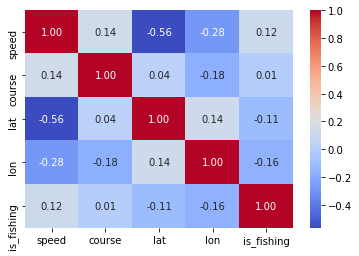

In [12]:
g = sns.heatmap(df_raw.select('speed', 'course', 'lat', 'lon', 'is_fishing').toPandas().corr(),
                annot=True, fmt = ".2f", cmap = "coolwarm")

In [13]:
import pyspark.sql.functions as f
df_nulls = df_raw.select([f.sum(f.col(c).isNull().cast('integer') / df_raw.count()).alias(c) for c in df_raw.columns])
df_nulls.show()

+----+---------+-------------------+------------------+-----+------+---+---+----------+------+
|mmsi|timestamp|distance_from_shore|distance_from_port|speed|course|lat|lon|is_fishing|source|
+----+---------+-------------------+------------------+-----+------+---+---+----------+------+
| 0.0|      0.0|                0.0|               0.0|  0.0|   0.0|0.0|0.0|       0.0|   0.0|
+----+---------+-------------------+------------------+-----+------+---+---+----------+------+



In [15]:
#w = Window.partitionBy('location_point').orderBy('timestamp').rangeBetween(-60*60,0)
#https://stackoverflow.com/questions/45531662/how-to-use-lag-and-rangebetween-functions-on-timestamp-values
from pyspark.sql import Window 
w = Window.partitionBy('mmsi').orderBy('timestamp').rangeBetween(-60*30,0)
df = df_raw.withColumn('occurrences_in_30_min',f.count('timestamp').over(w))
df.show(2)

+-----------------+----------+-------------------+------------------+-------------------+--------------+-------------+-------------+----------+------+---------------------+
|             mmsi| timestamp|distance_from_shore|distance_from_port|              speed|        course|          lat|          lon|is_fishing|source|occurrences_in_30_min|
+-----------------+----------+-------------------+------------------+-------------------+--------------+-------------+-------------+----------+------+---------------------+
|167072386810842.0|1325624789|                0.0|    17492.42578125|0.30000001190000003| 310.799987793|55.4751205444|14.2862281799|      -1.0|   gfw|                    1|
|167072386810842.0|1325625532|                0.0|    17492.42578125|       0.1000000015|304.3999938965|55.4750671387|14.2862195969|      -1.0|   gfw|                    2|
+-----------------+----------+-------------------+------------------+-------------------+--------------+-------------+-------------+---

In [17]:
from pyspark.sql.functions import lag
w = Window.partitionBy('mmsi').orderBy('timestamp')
df = df.withColumn('prev_timestamp', lag('timestamp', 1).over(w))
df = df.withColumn('diff_timestamp', (df['timestamp'] -df['prev_timestamp']) )
df.show(2)

+-----------------+----------+-------------------+------------------+-------------------+--------------+------------------+------------------+----------+------+---------------------+--------------+--------------+
|             mmsi| timestamp|distance_from_shore|distance_from_port|              speed|        course|               lat|               lon|is_fishing|source|occurrences_in_30_min|prev_timestamp|diff_timestamp|
+-----------------+----------+-------------------+------------------+-------------------+--------------+------------------+------------------+----------+------+---------------------+--------------+--------------+
|167072386810842.0|1325624789|                0.0|    17492.42578125|0.30000001190000003| 310.799987793|     55.4751205444|     14.2862281799|      -1.0|   gfw|                    1|          null|          null|
|167072386810842.0|1325625532|                0.0|    17492.42578125|       0.1000000015|304.3999938965|     55.4750671387|     14.2862195969|      

In [21]:
df.toPandas().to_csv('trolleres_featuered.csv')


In [22]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

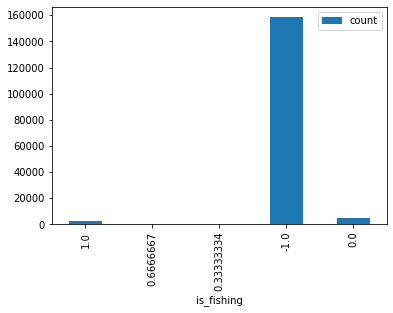

In [23]:
df.select('is_fishing').groupBy('is_fishing').count().toPandas().set_index('is_fishing').plot.bar()

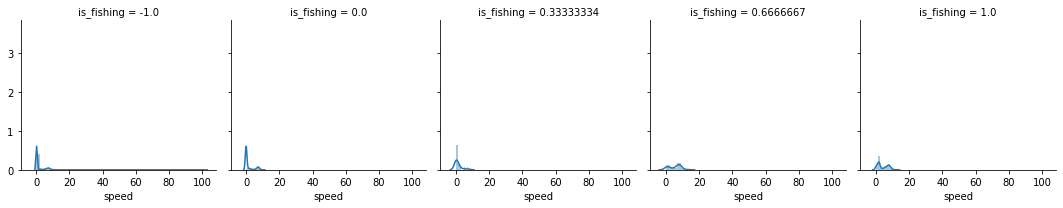

In [24]:
g = sns.FacetGrid(df.toPandas(), col='is_fishing')
g = g.map(sns.distplot, 'speed')